# Problem Set 7: Regression Analysis of Unilever Returns


## Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('DataPGUN.csv')
print(f"Data loaded: {len(data)} observations")
print(f"Date range: {data['Date'].iloc[0]} to {data['Date'].iloc[-1]}")
print(f"\nColumns: {list(data.columns)}")
data.head()

Data loaded: 264 observations
Date range: 1994-01-31 to 2015-12-31

Columns: ['Date', 'PG', 'UN', 'HH', 'MKT', 'RF']


,Date,PG,UN,HH,MKT,RF
0,1994-01-31,0.008772,0.004329,0.0247,0.0312,0.0025
1,1994-02-28,0.016397,0.020473,-0.0121,-0.0235,0.0021
2,1994-03-31,-0.019355,-0.061245,-0.0504,-0.0451,0.0027
3,1994-04-30,-0.078947,-0.087739,0.0164,0.0095,0.0027
4,1994-05-31,0.082419,0.092478,0.0092,0.0089,0.0031


In [2]:
# Extract variables
R_UL = data['UN'].values  # Unilever returns
R_PG = data['PG'].values  # Proctor & Gamble returns
R_HH = data['HH'].values  # Consumer Goods index
R_m = data['MKT'].values  # Market returns (CRSP-VW)
R_f = data['RF'].values   # Risk-free rate

# Compute excess returns
y = R_UL - R_f  # Unilever excess returns
x_mkt = R_m - R_f  # Market excess returns
x_hh = R_HH - R_f  # Consumer Goods excess returns

n = len(y)
print(f"Number of observations: {n}")

Number of observations: 264


## OLS Functions (No Built-in Packages)

In [3]:
def ols_regression(y, X):
    """OLS regression using matrix algebra"""
    n, k = X.shape
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    beta = XtX_inv @ X.T @ y
    y_hat = X @ beta
    e = y - y_hat
    SSR = e.T @ e
    SST = np.sum((y - np.mean(y))**2)
    R2 = 1 - SSR / SST
    R2_adj = 1 - (SSR / (n - k)) / (SST / (n - 1))
    return {
        'beta': beta, 'y_hat': y_hat, 'residuals': e,
        'SSR': SSR, 'SST': SST, 'R2': R2, 'R2_adj': R2_adj,
        'XtX_inv': XtX_inv, 'n': n, 'k': k
    }

def variance_covariance_ols(results):
    """Variance-covariance matrix under homoskedasticity"""
    e = results['residuals']
    n, k = results['n'], results['k']
    XtX_inv = results['XtX_inv']
    sigma2 = (e.T @ e) / (n - k)
    var_cov = sigma2 * XtX_inv
    return var_cov, sigma2

def variance_covariance_white(results, X):
    """White heteroskedasticity-robust variance-covariance"""
    e = results['residuals']
    n, k = results['n'], results['k']
    XtX_inv = results['XtX_inv']
    meat = np.zeros((k, k))
    for i in range(n):
        xi = X[i, :].reshape(-1, 1)
        meat += (e[i]**2) * (xi @ xi.T)
    return (n / (n - k)) * XtX_inv @ meat @ XtX_inv

def t_test(beta, se, n, k):
    """T-test for H0: beta = 0"""
    t_stat = beta / se
    df = n - k
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df))
    return {'t_stat': t_stat, 'p_value': p_value, 'df': df}

def confidence_interval(beta, se, n, k, conf_levels=[0.90, 0.95, 0.99]):
    """Compute confidence intervals"""
    df = n - k
    intervals = {}
    for conf in conf_levels:
        t_crit = stats.t.ppf(1 - (1-conf)/2, df)
        intervals[f'{int(conf*100)}%'] = (beta - t_crit * se, beta + t_crit * se)
    return intervals

In [4]:
def information_criteria(results):
    """Compute AIC, BIC, and Hannan-Quinn IC"""
    e = results['residuals']
    n, k = results['n'], results['k']
    sigma2 = (e.T @ e) / n
    log_lik = -n/2 * (np.log(2 * np.pi) + np.log(sigma2) + 1)
    AIC = -2 * log_lik + 2 * k
    BIC = -2 * log_lik + k * np.log(n)
    HQ = -2 * log_lik + 2 * k * np.log(np.log(n))
    return {'log_likelihood': log_lik, 'AIC': AIC, 'BIC': BIC, 'HQ': HQ}

def durbin_watson(residuals):
    """Durbin-Watson statistic"""
    diff_e = np.diff(residuals)
    return np.sum(diff_e**2) / np.sum(residuals**2)

def breusch_godfrey(y, X, residuals, lags=1):
    """Breusch-Godfrey test for serial correlation"""
    n = len(residuals)
    e_lag = np.zeros((n, lags))
    for i in range(lags):
        e_lag[i+1:, i] = residuals[:-(i+1)]
    X_aux = np.hstack([X, e_lag])
    XtX_aux = X_aux.T @ X_aux
    XtX_inv_aux = np.linalg.inv(XtX_aux)
    beta_aux = XtX_inv_aux @ X_aux.T @ residuals
    e_aux = residuals - X_aux @ beta_aux
    SSR_aux = e_aux.T @ e_aux
    SST_aux = np.sum((residuals - np.mean(residuals))**2)
    R2_aux = 1 - SSR_aux / SST_aux
    bg_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(bg_stat, lags)
    return bg_stat, p_value

def breusch_pagan(y, X, residuals):
    """Breusch-Pagan test for heteroskedasticity"""
    n = len(residuals)
    k = X.shape[1]
    e2 = residuals**2
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    gamma = XtX_inv @ X.T @ e2
    e2_hat = X @ gamma
    u = e2 - e2_hat
    SSR_aux = u.T @ u
    SST_aux = np.sum((e2 - np.mean(e2))**2)
    R2_aux = 1 - SSR_aux / SST_aux
    bp_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(bp_stat, k - 1)
    return bp_stat, p_value

def white_test(y, X, residuals):
    """White test for heteroskedasticity"""
    n = len(residuals)
    k = X.shape[1]
    e2 = residuals**2
    if k == 2:
        x = X[:, 1]
        X_aux = np.column_stack([np.ones(n), x, x**2])
    else:
        X_aux_list = [np.ones(n)]
        for i in range(1, k):
            X_aux_list.append(X[:, i])
        for i in range(1, k):
            X_aux_list.append(X[:, i]**2)
        for i in range(1, k):
            for j in range(i+1, k):
                X_aux_list.append(X[:, i] * X[:, j])
        X_aux = np.column_stack(X_aux_list)
    k_aux = X_aux.shape[1]
    XtX_aux = X_aux.T @ X_aux
    XtX_inv_aux = np.linalg.inv(XtX_aux)
    gamma = XtX_inv_aux @ X_aux.T @ e2
    e2_hat = X_aux @ gamma
    u = e2 - e2_hat
    SSR_aux = u.T @ u
    SST_aux = np.sum((e2 - np.mean(e2))**2)
    R2_aux = 1 - SSR_aux / SST_aux
    white_stat = n * R2_aux
    p_value = 1 - stats.chi2.cdf(white_stat, k_aux - 1)
    return white_stat, p_value, k_aux - 1

In [5]:
def jarque_bera(residuals):
    """Jarque-Bera test for normality"""
    n = len(residuals)
    e_std = (residuals - np.mean(residuals)) / np.std(residuals, ddof=1)
    skew = np.mean(e_std**3)
    kurt = np.mean(e_std**4)
    jb_stat = n * (skew**2 / 6 + (kurt - 3)**2 / 24)
    p_value = 1 - stats.chi2.cdf(jb_stat, 2)
    return jb_stat, p_value, skew, kurt

def ramsey_reset(y, X, residuals, powers=[2, 3]):
    """Ramsey RESET test for functional form"""
    n = len(y)
    k = X.shape[1]
    y_hat = y - residuals
    X_aux_list = [X]
    for p in powers:
        X_aux_list.append((y_hat**p).reshape(-1, 1))
    X_aux = np.hstack(X_aux_list)
    k_aux = X_aux.shape[1]
    XtX_aux = X_aux.T @ X_aux
    XtX_inv_aux = np.linalg.inv(XtX_aux)
    beta_aux = XtX_inv_aux @ X_aux.T @ y
    e_aux = y - X_aux @ beta_aux
    SSR_r = residuals.T @ residuals
    SSR_ur = e_aux.T @ e_aux
    q = len(powers)
    F_stat = ((SSR_r - SSR_ur) / q) / (SSR_ur / (n - k_aux))
    p_value = 1 - stats.f.cdf(F_stat, q, n - k_aux)
    return F_stat, p_value

def vif(X):
    """Variance Inflation Factor"""
    k = X.shape[1]
    vif_values = []
    for i in range(1, k):
        X_others = np.delete(X, i, axis=1)
        y_i = X[:, i]
        XtX = X_others.T @ X_others
        XtX_inv = np.linalg.inv(XtX)
        beta = XtX_inv @ X_others.T @ y_i
        y_hat = X_others @ beta
        e = y_i - y_hat
        SSR = e.T @ e
        SST = np.sum((y_i - np.mean(y_i))**2)
        R2_i = 1 - SSR / SST
        vif_i = 1 / (1 - R2_i) if R2_i < 1 else np.inf
        vif_values.append(vif_i)
    return vif_values

---
# Question 1: Simple CAPM Regression

$$R_{UL,t} - R_{f,t} = \alpha + \beta (R_{m,t} - R_{f,t}) + e_t$$

In [6]:
# Design matrix with intercept
X1 = np.column_stack([np.ones(n), x_mkt])

# Run OLS
results1 = ols_regression(y, X1)

### (a) Coefficient Estimates, R², and Adjusted R²

In [7]:
print("--- (a) Coefficient Estimates ---")
print(f"alpha (intercept): {results1['beta'][0]:.6f}")
print(f"beta (market):     {results1['beta'][1]:.6f}")
print(f"R-squared:         {results1['R2']:.6f}")
print(f"Adjusted R-squared:{results1['R2_adj']:.6f}")

--- (a) Coefficient Estimates ---
alpha (intercept): 0.008043
beta (market):     0.052430
R-squared:         0.001178
Adjusted R-squared:-0.002635


### (b) Scatterplot with Regression Line

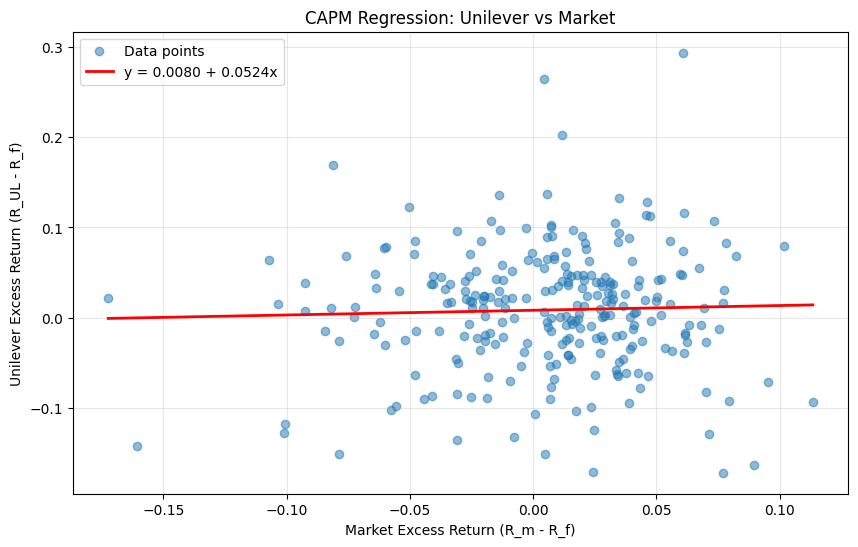

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(x_mkt, y, alpha=0.5, label='Data points')
x_line = np.linspace(min(x_mkt), max(x_mkt), 100)
y_line = results1['beta'][0] + results1['beta'][1] * x_line
plt.plot(x_line, y_line, 'r-', linewidth=2, 
         label=f'y = {results1["beta"][0]:.4f} + {results1["beta"][1]:.4f}x')
plt.xlabel('Market Excess Return (R_m - R_f)')
plt.ylabel('Unilever Excess Return (R_UL - R_f)')
plt.title('CAPM Regression: Unilever vs Market')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### (c) Variance-Covariance Matrix (Homoskedasticity)

In [9]:
var_cov_ols1, sigma2_1 = variance_covariance_ols(results1)
print(f"Estimated sigma^2: {sigma2_1:.8f}")
print(f"\nVariance-Covariance Matrix:")
print(f"         alpha        beta")
print(f"alpha   {var_cov_ols1[0,0]:.8f}  {var_cov_ols1[0,1]:.8f}")
print(f"beta    {var_cov_ols1[1,0]:.8f}  {var_cov_ols1[1,1]:.8f}")

se_ols1 = np.sqrt(np.diag(var_cov_ols1))
print(f"\nStandard Errors (OLS):")
print(f"SE(alpha): {se_ols1[0]:.6f}")
print(f"SE(beta):  {se_ols1[1]:.6f}")

Estimated sigma^2: 0.00456382

Variance-Covariance Matrix:
         alpha        beta
alpha   0.00001762  -0.00005418
beta    -0.00005418  0.00889909

Standard Errors (OLS):
SE(alpha): 0.004197
SE(beta):  0.094335


### (d) T-tests (Homoskedasticity)

In [10]:
for i, name in enumerate(['alpha', 'beta']):
    t_res = t_test(results1['beta'][i], se_ols1[i], results1['n'], results1['k'])
    t_crit_1 = stats.t.ppf(0.995, t_res['df'])
    t_crit_5 = stats.t.ppf(0.975, t_res['df'])
    t_crit_10 = stats.t.ppf(0.95, t_res['df'])
    print(f"\n{name}:")
    print(f"  t-statistic: {t_res['t_stat']:.4f}")
    print(f"  p-value:     {t_res['p_value']:.6f}")
    print(f"  Reject at 1%:  {abs(t_res['t_stat']) > t_crit_1}")
    print(f"  Reject at 5%:  {abs(t_res['t_stat']) > t_crit_5}")
    print(f"  Reject at 10%: {abs(t_res['t_stat']) > t_crit_10}")


alpha:
  t-statistic: 1.9164
  p-value:     0.056408
  Reject at 1%:  False
  Reject at 5%:  False
  Reject at 10%: True

beta:
  t-statistic: 0.5558
  p-value:     0.578836
  Reject at 1%:  False
  Reject at 5%:  False
  Reject at 10%: False


### (e) Heteroskedasticity Assessment

In [11]:
bp_stat, bp_pval = breusch_pagan(y, X1, results1['residuals'])
print(f"Breusch-Pagan Test:")
print(f"  Test statistic: {bp_stat:.4f}")
print(f"  p-value:        {bp_pval:.6f}")
print(f"  Reject H0 (homoskedasticity) at 5%: {bp_pval < 0.05}")

white_stat, white_pval, white_df = white_test(y, X1, results1['residuals'])
print(f"\nWhite Test:")
print(f"  Test statistic: {white_stat:.4f}")
print(f"  Degrees of freedom: {white_df}")
print(f"  p-value:        {white_pval:.6f}")
print(f"  Reject H0 (homoskedasticity) at 5%: {white_pval < 0.05}")

Breusch-Pagan Test:
  Test statistic: 0.2621
  p-value:        0.608661
  Reject H0 (homoskedasticity) at 5%: False

White Test:
  Test statistic: 6.1981
  Degrees of freedom: 2
  p-value:        0.045093
  Reject H0 (homoskedasticity) at 5%: True


### (f) Confidence Intervals (Homoskedasticity)

In [12]:
for i, name in enumerate(['alpha', 'beta']):
    ci = confidence_interval(results1['beta'][i], se_ols1[i], results1['n'], results1['k'])
    print(f"\n{name} = {results1['beta'][i]:.6f}")
    for level, (lower, upper) in ci.items():
        print(f"  {level} CI: [{lower:.6f}, {upper:.6f}]")


alpha = 0.008043
  90% CI: [0.001115, 0.014972]
  95% CI: [-0.000221, 0.016308]
  99% CI: [-0.002847, 0.018934]

beta = 0.052430
  90% CI: [-0.103288, 0.208147]
  95% CI: [-0.133322, 0.238181]
  99% CI: [-0.192344, 0.297203]


### (g) White Variance-Covariance Matrix

In [13]:
var_cov_white1 = variance_covariance_white(results1, X1)
print(f"White Variance-Covariance Matrix:")
print(f"         alpha        beta")
print(f"alpha   {var_cov_white1[0,0]:.8f}  {var_cov_white1[0,1]:.8f}")
print(f"beta    {var_cov_white1[1,0]:.8f}  {var_cov_white1[1,1]:.8f}")

se_white1 = np.sqrt(np.diag(var_cov_white1))
print(f"\nStandard Errors (White):")
print(f"SE(alpha): {se_white1[0]:.6f}")
print(f"SE(beta):  {se_white1[1]:.6f}")

White Variance-Covariance Matrix:
         alpha        beta
alpha   0.00001747  -0.00005344
beta    -0.00005344  0.01263102

Standard Errors (White):
SE(alpha): 0.004180
SE(beta):  0.112388


### (h) Confidence Intervals (White)

In [14]:
for i, name in enumerate(['alpha', 'beta']):
    ci = confidence_interval(results1['beta'][i], se_white1[i], results1['n'], results1['k'])
    print(f"\n{name} = {results1['beta'][i]:.6f}")
    for level, (lower, upper) in ci.items():
        print(f"  {level} CI: [{lower:.6f}, {upper:.6f}]")


alpha = 0.008043
  90% CI: [0.001144, 0.014943]
  95% CI: [-0.000187, 0.016274]
  99% CI: [-0.002802, 0.018889]

beta = 0.052430
  90% CI: [-0.133088, 0.237947]
  95% CI: [-0.168869, 0.273728]
  99% CI: [-0.239186, 0.344045]


### (i) T-tests (White Standard Errors)

In [15]:
for i, name in enumerate(['alpha', 'beta']):
    t_res = t_test(results1['beta'][i], se_white1[i], results1['n'], results1['k'])
    t_crit_1 = stats.t.ppf(0.995, t_res['df'])
    t_crit_5 = stats.t.ppf(0.975, t_res['df'])
    t_crit_10 = stats.t.ppf(0.95, t_res['df'])
    print(f"\n{name}:")
    print(f"  t-statistic: {t_res['t_stat']:.4f}")
    print(f"  p-value:     {t_res['p_value']:.6f}")
    print(f"  Reject at 1%:  {abs(t_res['t_stat']) > t_crit_1}")
    print(f"  Reject at 5%:  {abs(t_res['t_stat']) > t_crit_5}")
    print(f"  Reject at 10%: {abs(t_res['t_stat']) > t_crit_10}")


alpha:
  t-statistic: 1.9244
  p-value:     0.055384
  Reject at 1%:  False
  Reject at 5%:  False
  Reject at 10%: True

beta:
  t-statistic: 0.4665
  p-value:     0.641242
  Reject at 1%:  False
  Reject at 5%:  False
  Reject at 10%: False


### (j) Information Criteria

In [16]:
ic1 = information_criteria(results1)
print(f"Log-likelihood: {ic1['log_likelihood']:.4f}")
print(f"AIC:            {ic1['AIC']:.4f}")
print(f"BIC:            {ic1['BIC']:.4f}")
print(f"Hannan-Quinn:   {ic1['HQ']:.4f}")

Log-likelihood: 337.8306
AIC:            -671.6612
BIC:            -664.5093
Hannan-Quinn:   -668.7874


### (k) Serial Correlation Tests

In [17]:
dw1 = durbin_watson(results1['residuals'])
print(f"Durbin-Watson statistic: {dw1:.4f}")
print(f"Interpretation: DW close to 2 = no autocorrelation")

bg_stat1, bg_pval1 = breusch_godfrey(y, X1, results1['residuals'], lags=1)
print(f"\nBreusch-Godfrey Test (1 lag):")
print(f"  Test statistic: {bg_stat1:.4f}")
print(f"  p-value:        {bg_pval1:.6f}")
print(f"  Reject H0 (no autocorrelation) at 5%: {bg_pval1 < 0.05}")

Durbin-Watson statistic: 2.3139
Interpretation: DW close to 2 = no autocorrelation

Breusch-Godfrey Test (1 lag):
  Test statistic: 6.6178
  p-value:        0.010096
  Reject H0 (no autocorrelation) at 5%: True


### (l) Normality Tests

In [18]:
jb_stat, jb_pval, skew, kurt = jarque_bera(results1['residuals'])
print(f"Jarque-Bera Test:")
print(f"  Skewness:       {skew:.4f}")
print(f"  Kurtosis:       {kurt:.4f}")
print(f"  Test statistic: {jb_stat:.4f}")
print(f"  p-value:        {jb_pval:.6f}")
print(f"  Reject H0 (normality) at 5%: {jb_pval < 0.05}")

sw_stat, sw_pval = stats.shapiro(results1['residuals'])
print(f"\nShapiro-Wilk Test:")
print(f"  Test statistic: {sw_stat:.4f}")
print(f"  p-value:        {sw_pval:.6f}")
print(f"  Reject H0 (normality) at 5%: {sw_pval < 0.05}")

Jarque-Bera Test:
  Skewness:       0.1695
  Kurtosis:       4.5695
  Test statistic: 28.3617
  p-value:        0.000001
  Reject H0 (normality) at 5%: True

Shapiro-Wilk Test:
  Test statistic: 0.9771
  p-value:        0.000293
  Reject H0 (normality) at 5%: True


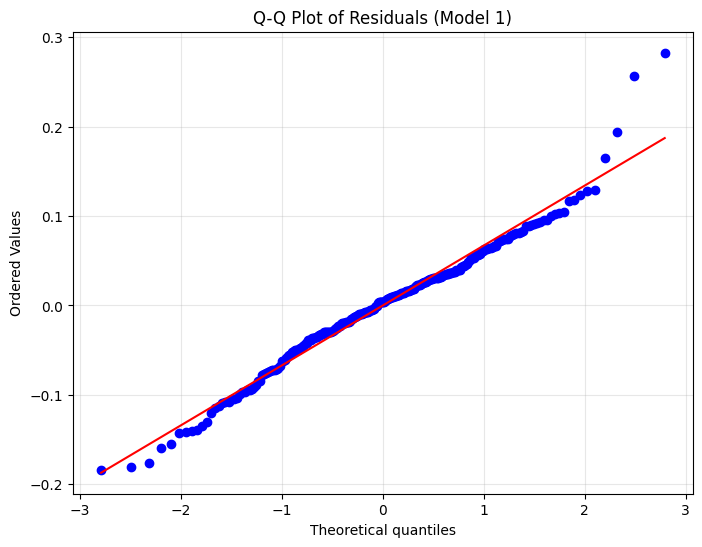

In [19]:
# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(results1['residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Model 1)')
plt.grid(True, alpha=0.3)
plt.show()

### (m) Multicollinearity Check

In [20]:
print("For simple regression with one regressor, multicollinearity is not applicable.")
print("The design matrix only contains the intercept and one regressor (market return).")

For simple regression with one regressor, multicollinearity is not applicable.
The design matrix only contains the intercept and one regressor (market return).


### (n) Functional Form Test

In [21]:
reset_stat, reset_pval = ramsey_reset(y, X1, results1['residuals'])
print(f"Ramsey RESET Test:")
print(f"  F-statistic: {reset_stat:.4f}")
print(f"  p-value:     {reset_pval:.6f}")
print(f"  Reject H0 (correct specification) at 5%: {reset_pval < 0.05}")

Ramsey RESET Test:
  F-statistic: 2.5170
  p-value:     0.082664
  Reject H0 (correct specification) at 5%: False


### (o) Rolling Regressions (60-month window)

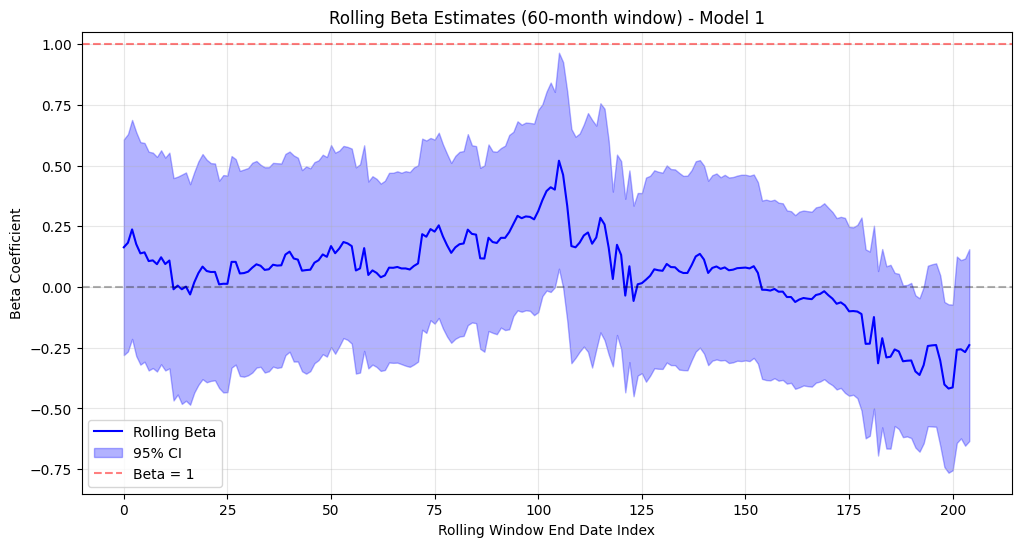

Rolling Beta Statistics:
  Mean:   0.0564
  Std:    0.1676
  Min:    -0.4180
  Max:    0.5198


In [22]:
window = 60
n_rolls = n - window + 1

rolling_beta = np.zeros(n_rolls)
rolling_se_beta = np.zeros(n_rolls)
rolling_dates = []

for i in range(n_rolls):
    y_roll = y[i:i+window]
    X_roll = X1[i:i+window, :]
    results_roll = ols_regression(y_roll, X_roll)
    var_cov_roll, _ = variance_covariance_ols(results_roll)
    rolling_beta[i] = results_roll['beta'][1]
    rolling_se_beta[i] = np.sqrt(var_cov_roll[1, 1])
    rolling_dates.append(data['Date'].iloc[i + window - 1])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(n_rolls), rolling_beta, 'b-', linewidth=1.5, label='Rolling Beta')
t_crit = stats.t.ppf(0.975, window - 2)
upper = rolling_beta + t_crit * rolling_se_beta
lower = rolling_beta - t_crit * rolling_se_beta
plt.fill_between(range(n_rolls), lower, upper, alpha=0.3, color='blue', label='95% CI')
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Beta = 1')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Rolling Window End Date Index')
plt.ylabel('Beta Coefficient')
plt.title('Rolling Beta Estimates (60-month window) - Model 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Rolling Beta Statistics:")
print(f"  Mean:   {np.mean(rolling_beta):.4f}")
print(f"  Std:    {np.std(rolling_beta):.4f}")
print(f"  Min:    {np.min(rolling_beta):.4f}")
print(f"  Max:    {np.max(rolling_beta):.4f}")

---
# Question 2: Two-Factor Regression

$$R_{UL,t} - R_{f,t} = \alpha + \beta (R_{m,t} - R_{f,t}) + \gamma (R_{HH,t} - R_{f,t}) + e_t$$

In [23]:
# Design matrix with intercept and two factors
X2 = np.column_stack([np.ones(n), x_mkt, x_hh])
results2 = ols_regression(y, X2)

### (a) Coefficient Estimates

In [24]:
print("--- (a) Coefficient Estimates ---")
print(f"alpha (intercept):      {results2['beta'][0]:.6f}")
print(f"beta (market):          {results2['beta'][1]:.6f}")
print(f"gamma (consumer goods): {results2['beta'][2]:.6f}")
print(f"R-squared:              {results2['R2']:.6f}")
print(f"Adjusted R-squared:     {results2['R2_adj']:.6f}")

--- (a) Coefficient Estimates ---
alpha (intercept):      0.008244
beta (market):          0.096757
gamma (consumer goods): -0.074865
R-squared:              0.002517
Adjusted R-squared:     -0.005127


### (b) - (o) Two-Factor Model Analysis

Similar analysis as Question 1, now with two regressors. Key differences include multicollinearity check with VIF.

In [25]:
# Variance-covariance matrices
var_cov_ols2, sigma2_2 = variance_covariance_ols(results2)
var_cov_white2 = variance_covariance_white(results2, X2)
se_ols2 = np.sqrt(np.diag(var_cov_ols2))
se_white2 = np.sqrt(np.diag(var_cov_white2))

print("Standard Errors:")
print(f"{'':15} {'OLS':>12} {'White':>12}")
for i, name in enumerate(['alpha', 'beta', 'gamma']):
    print(f"{name:15} {se_ols2[i]:>12.6f} {se_white2[i]:>12.6f}")

Standard Errors:
                         OLS        White
alpha               0.004216     0.004257
beta                0.120535     0.152236
gamma               0.126472     0.159255


In [26]:
# Multicollinearity check
vif_values = vif(X2)
print("\nVariance Inflation Factors:")
print(f"  VIF(beta - market):          {vif_values[0]:.4f}")
print(f"  VIF(gamma - consumer goods): {vif_values[1]:.4f}")
print(f"\nCorrelation between market and consumer goods: {np.corrcoef(x_mkt, x_hh)[0,1]:.4f}")
print("\nInterpretation: VIF > 10 indicates severe multicollinearity")


Variance Inflation Factors:
  VIF(beta - market):          1.6286
  VIF(gamma - consumer goods): 1.6286

Correlation between market and consumer goods: 0.6213

Interpretation: VIF > 10 indicates severe multicollinearity


---
# Question 3: Model Comparison

In [27]:
ic2 = information_criteria(results2)

print("Model Comparison Summary")
print("=" * 50)
print(f"{'Metric':<25} {'Model 1':>12} {'Model 2':>12}")
print("-" * 50)
print(f"{'R-squared':<25} {results1['R2']:>12.6f} {results2['R2']:>12.6f}")
print(f"{'Adjusted R-squared':<25} {results1['R2_adj']:>12.6f} {results2['R2_adj']:>12.6f}")
print(f"{'AIC':<25} {ic1['AIC']:>12.4f} {ic2['AIC']:>12.4f}")
print(f"{'BIC':<25} {ic1['BIC']:>12.4f} {ic2['BIC']:>12.4f}")
print(f"{'SSR':<25} {results1['SSR']:>12.6f} {results2['SSR']:>12.6f}")

Model Comparison Summary
Metric                         Model 1      Model 2
--------------------------------------------------
R-squared                     0.001178     0.002517
Adjusted R-squared           -0.002635    -0.005127
AIC                          -671.6612    -670.0154
BIC                          -664.5093    -659.2876
SSR                           1.195721     1.194118


In [28]:
# F-test for nested models
SSR_r = results1['SSR']
SSR_ur = results2['SSR']
q = 1
F_nested = ((SSR_r - SSR_ur) / q) / (SSR_ur / (n - 3))
p_nested = 1 - stats.f.cdf(F_nested, q, n - 3)

print(f"\nF-test for Nested Models:")
print(f"H0: gamma = 0 (Model 1 is correct)")
print(f"F-statistic: {F_nested:.4f}")
print(f"p-value:     {p_nested:.6f}")
print(f"Reject H0 at 5%: {p_nested < 0.05}")
print(f"\nConclusion: Model 1 (simple CAPM) is preferred.")


F-test for Nested Models:
H0: gamma = 0 (Model 1 is correct)
F-statistic: 0.3504
p-value:     0.554396
Reject H0 at 5%: False

Conclusion: Model 1 (simple CAPM) is preferred.


---
# Question 4: Current Market Betas for PG and UL

In [29]:
# Run CAPM regression for PG
y_pg = R_PG - R_f
X_pg = np.column_stack([np.ones(n), x_mkt])
results_pg = ols_regression(y_pg, X_pg)
var_cov_pg, _ = variance_covariance_ols(results_pg)
var_cov_white_pg = variance_covariance_white(results_pg, X_pg)

print("Full Sample CAPM Results")
print("=" * 60)
print(f"{'Stock':<15} {'Beta':>10} {'OLS SE':>12} {'White SE':>12} {'R2':>10}")
print("-" * 60)
print(f"{'PG':<15} {results_pg['beta'][1]:>10.4f} {np.sqrt(var_cov_pg[1,1]):>12.4f} {np.sqrt(var_cov_white_pg[1,1]):>12.4f} {results_pg['R2']:>10.4f}")
print(f"{'UL':<15} {results1['beta'][1]:>10.4f} {se_ols1[1]:>12.4f} {se_white1[1]:>12.4f} {results1['R2']:>10.4f}")

Full Sample CAPM Results
Stock                 Beta       OLS SE     White SE         R2
------------------------------------------------------------
PG                  0.1768       0.0788       0.1056     0.0188
UL                  0.0524       0.0943       0.1124     0.0012


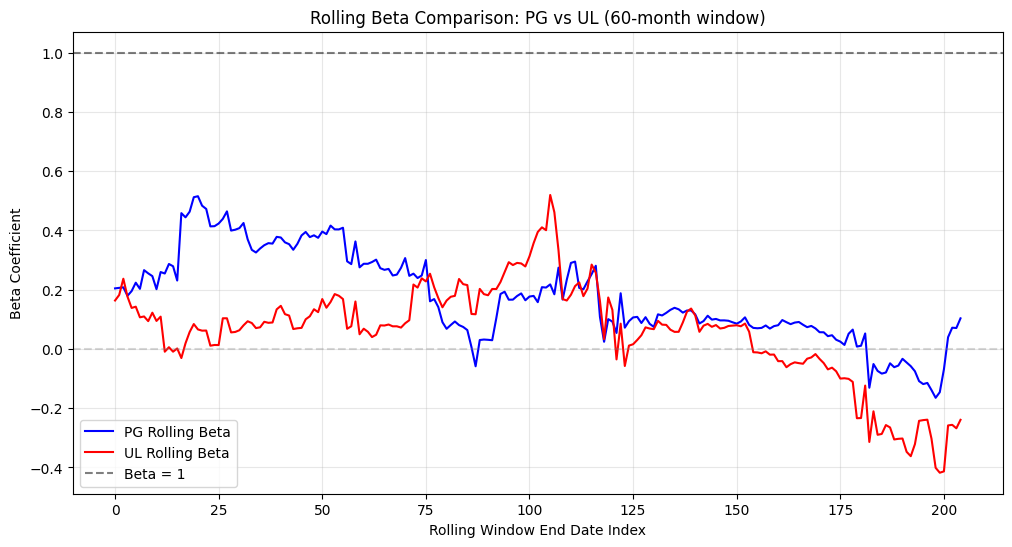


Current (last window) Beta Estimates:
  PG: 0.1033
  UL: -0.2394


In [30]:
# Rolling betas comparison
rolling_beta_pg = np.zeros(n_rolls)
for i in range(n_rolls):
    y_roll = y_pg[i:i+window]
    X_roll = X_pg[i:i+window, :]
    results_roll = ols_regression(y_roll, X_roll)
    rolling_beta_pg[i] = results_roll['beta'][1]

plt.figure(figsize=(12, 6))
plt.plot(range(n_rolls), rolling_beta_pg, 'b-', linewidth=1.5, label='PG Rolling Beta')
plt.plot(range(n_rolls), rolling_beta, 'r-', linewidth=1.5, label='UL Rolling Beta')
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Beta = 1')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.xlabel('Rolling Window End Date Index')
plt.ylabel('Beta Coefficient')
plt.title('Rolling Beta Comparison: PG vs UL (60-month window)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nCurrent (last window) Beta Estimates:")
print(f"  PG: {rolling_beta_pg[-1]:.4f}")
print(f"  UL: {rolling_beta[-1]:.4f}")